In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [1]:
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
import os
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from scipy.spatial import distance as dist
from imutils import face_utils
from imutils.face_utils import *

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [2]:
cd M:\IIST\SEM 2\COMPUTER VISION\Project\FaceAttributeRecognition

M:\IIST\SEM 2\COMPUTER VISION\Project\FaceAttributeRecognition


In [3]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()

In [4]:
smodel = load_model("smile_model.h5")
gmodel = load_model("glass_model.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
ls

 Volume in drive M is MACHINE LEARNING
 Volume Serial Number is 4E23-4B98

 Directory of M:\IIST\SEM 2\COMPUTER VISION\Project\FaceAttributeRecognition

22-04-2021  22:09    <DIR>          .
22-04-2021  22:09    <DIR>          ..
22-04-2021  21:56            56,825 1.jpg
22-04-2021  22:02           412,128 2.png
22-04-2021  22:05            53,427 3.jpg
22-04-2021  22:09            18,873 4.jpg
22-04-2021  22:09            24,502 5.jpg
19-04-2021  23:50        98,000,912 age_gen_mw.h5
20-04-2021  10:37    <DIR>          Code
19-04-2021  23:33       104,188,200 gender_detection.model
19-04-2021  22:54        17,307,064 glass_model.h5
22-04-2021  20:18    <DIR>          glasses_dataset
19-04-2021  23:59    <DIR>          images
30-03-2021  06:36    <DIR>          neutral_smile
12-02-2021  23:06        99,693,937 shape_predictor_68_face_landmarks.dat
19-04-2021  22:34         2,077,632 smile_model.h5
              10 File(s)    321,833,500 bytes
               6 Dir(s)  259,158,851,584 by

In [19]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
smodel = load_model("smile_model.h5")
gmodel = load_model("glass_model.h5")
agmodel = load_model('age_gen_mw.h5')

def eye(image, gray, rect, Threshold):
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)

    #simple hack ;)
    if (len(shape)==68):
        # extract the left and right eye (x, y)-coordinates
        (lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
        (rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
        (mStart, mEnd) = FACIAL_LANDMARKS_68_IDXS["mouth"]
    

    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
    #mouth= shape[mStart:mEnd]
    
    # Calculating the eyes aspect_ratio 
    A = dist.euclidean(leftEyePts[1], leftEyePts[5])
    B = dist.euclidean(leftEyePts[2], leftEyePts[4])
    C = dist.euclidean(leftEyePts[0], leftEyePts[3])
    leftEye_ar = (A + B) / (2.0 * C)

    D = dist.euclidean(rightEyePts[1], rightEyePts[5])
    E = dist.euclidean(rightEyePts[2], rightEyePts[4])
    F = dist.euclidean(rightEyePts[0], rightEyePts[3])
    rightEye_ar = (D + E) / (2.0 * F)
    
    if leftEye_ar > Threshold:
        if rightEye_ar > Threshold:
            statement1 = " Both eyes are open"
        else:
            statement1 = " Left Eye is open and right eye is closed"
    else:
        if rightEye_ar > Threshold:
            statement1 = " right Eye is open and left eye is closed"
        else:
            statement1 = " Both eyes are closed"

    return statement1

def smilemodel(face):
    predicted_emotions = smodel.predict(face)[0]
    best_emotion = ' YES' if predicted_emotions[1] > predicted_emotions[0] else ' NO'
    return best_emotion

def glass(face):
    gresult = gmodel.predict(face)[0]
    res = ' NO' if gresult[1] > gresult[0] else ' YES'
    return res

def aggface(face):
    sface = cv2.resize(face, (64, 64)).reshape((1, 64, 64, 3))
    if len(sface) > 0:
        results = agmodel.predict(sface)
        predicted_genders = results[0]
        gender = "F" if predicted_genders[0][0] > 0.5 else "M"
        return gender

def predict_attributes(img):
    image = cv2.imread(img)
    image = imutils.resize(image, width=700)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)   # detect faces in the grayscale image
    print(rects)
    for i,rect in enumerate(rects):
        (x, y, w, h) = rect_to_bb(rect)
        x = max(0,rect.left())
        y = max(0,rect.top())
        face1 = gray[y:y+h, x:x+w]
        print(face1.shape)
        face2 = image[max(0,y-int((0.2*h))):y+h+int((0.2*h)), x-int(0.2*w):x+w+int(0.2*w)]
        plt.imshow(face2)
        ey = eye(image, gray, rect, 0.2)

        sface = cv2.resize(face1, (48, 48)).reshape((1, 48, 48, 1))
        sm = smilemodel(sface)

        gface = cv2.resize(face1, (48, 48))
        cv2.imwrite('images/test.jpg',gface)
        gface = cv2.imread('images/test.jpg')
        gface = gface.reshape((1,48, 48, 3))
        gl = glass(gface)

        ge = aggface(face2)
        print('face #',str(i),',\n Eyes:',ey,',\n Smiling:',sm,',\n Glasses:',gl,',\n Gender:',ge)

C:\Users\Bharadwaj\.conda\envs\gputest\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### input 1

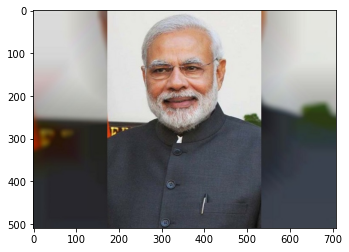

In [20]:
import matplotlib.pyplot as plt
import cv2
a = plt.imread("1.jpg")
plt.imshow(a)

### Output 1

rectangles[[(242, 77) (428, 263)]]
(186, 186)
face # 0 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  YES ,
 Gender: M


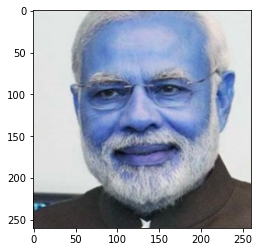

In [21]:
predict_attributes("1.jpg")

### input 2

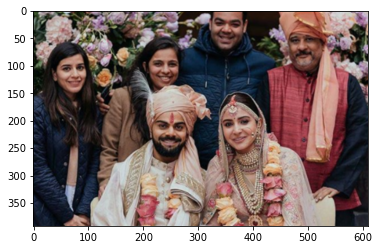

In [22]:
import matplotlib.pyplot as plt
import cv2
a = plt.imread("2.png")
plt.imshow(a)

### Output 2

rectangles[[(246, 94) (308, 156)], [(46, 96) (121, 171)], [(370, 5) (444, 80)], [(386, 213) (461, 287)], [(254, 221) (328, 296)], [(527, 38) (602, 113)]]
(62, 62)
face # 0 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: F
(75, 75)
face # 1 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: F
(75, 74)
face # 2 ,
 Eyes:  Left Eye is open and right eye is closed ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: M
(74, 75)
face # 3 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: F
(75, 74)
face # 4 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: M
(75, 75)
face # 5 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: M


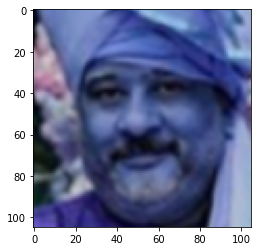

In [23]:
predict_attributes("2.png")

### input 3

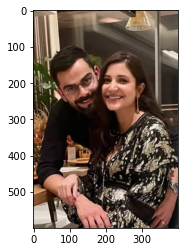

In [34]:
import matplotlib.pyplot as plt
import cv2
a = plt.imread("3.jpg")
plt.imshow(a)

### output 3

In [35]:
predict_attributes("3.jpg")

rectangles[[(304, 284) (489, 469)], [(139, 304) (324, 490)]]
(185, 185)
face # 0 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  NO ,
 Gender: F
(186, 185)
face # 1 ,
 Eyes:  Both eyes are open ,
 Smiling:  YES ,
 Glasses:  YES ,
 Gender: M


### input 4

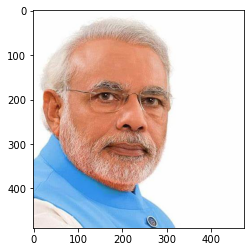

In [39]:
import matplotlib.pyplot as plt
import cv2
a = plt.imread("5.jpg")
plt.imshow(a)

### Output 4

In [40]:
predict_attributes("5.jpg")

rectangles[[(118, 162) (504, 547)]]
(385, 386)
face # 0 ,
 Eyes:  Both eyes are open ,
 Smiling:  NO ,
 Glasses:  YES ,
 Gender: M
